# Data Augmentation- VAE, Diffusion

> This script adopts HRV dataset for 3-class disease classification. \
> Major Depressive Disorder, Panic Disorder, Control. \
> Also contains various psychological scales (HAMD, HAMA, ...)

In [1]:
import os
import time
# import shap ## for XAI
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
# import pingouin as pg
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

In [2]:
from numpy import dot
from numpy.linalg import norm

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.layers import Dense , Activation, Dropout, BatchNormalization
from keras.optimizers import Adam ,RMSprop
from keras.callbacks import Callback

from scipy.special import rel_entr
from scipy.stats import gaussian_kde
from scipy.spatial.distance import jensenshannon

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, ParameterGrid
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix, roc_auc_score, classification_report, precision_score, recall_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import Normalizer, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.manifold import TSNE

from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Concatenate, Dense, Lambda, Conv1D, Flatten, Reshape, UpSampling1D, MaxPooling1D, concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.losses import mse, MeanSquaredError

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD
import numpy as np

In [4]:
scaler = MinMaxScaler() #set the scaler (between 0 and 1)
# scaler = StandardScaler()

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

***

---

## Dataset

In [6]:
data_ori = pd.read_csv('E:/RESEARCH/Datasets/dissertation/hrv_ja.csv')

In [7]:
data_ori.shape

(1748, 38)

In [8]:
data_ori.columns

Index(['subject', 'gender', 'age', 'auto_activity', 'auto_balance',
       'stress_resist', 'stress_index', 'tired', 'avg_hr', 'heart_stable',
       'abnormal_hr', 'sdnn', 'psi', 'tp', 'vlf', 'lf', 'hf', 'lfnorm',
       'hfnorm', 'lf_hf', 'rmssd', 'apen', 'srd', 'tsrd', 'tp_ln', 'vlf_ln',
       'lf_ln', 'hf_ln', 'main_dx', 'subtype', 'second_dx', 'third_dx', 'HAMD',
       'HAMA', 'BDI-II', 'BAI', 'MDQ', 'HCL-32'],
      dtype='object')

In [9]:
### data shape, variables check
print(f"The shape of the preprocessed research dataset is: {data_ori.shape}")

The shape of the preprocessed research dataset is: (1748, 38)


In [10]:
# 결측값이 하나라도 있는 행의 개수 확인
num_missing_rows = data_ori.isna().any(axis=1).sum()
print(f"The number of rows of the original dataset is: {data_ori.shape[0]}")
print(f"The number of rows that contains at least one missing value: {num_missing_rows}")

The number of rows of the original dataset is: 1748
The number of rows that contains at least one missing value: 1725


### target check

In [11]:
data_ori.columns

Index(['subject', 'gender', 'age', 'auto_activity', 'auto_balance',
       'stress_resist', 'stress_index', 'tired', 'avg_hr', 'heart_stable',
       'abnormal_hr', 'sdnn', 'psi', 'tp', 'vlf', 'lf', 'hf', 'lfnorm',
       'hfnorm', 'lf_hf', 'rmssd', 'apen', 'srd', 'tsrd', 'tp_ln', 'vlf_ln',
       'lf_ln', 'hf_ln', 'main_dx', 'subtype', 'second_dx', 'third_dx', 'HAMD',
       'HAMA', 'BDI-II', 'BAI', 'MDQ', 'HCL-32'],
      dtype='object')

In [12]:
data_ori.main_dx.value_counts() ## main_dx that contains more than 100 patients are only adopted for this research

main_dx
MDDs       325
MDDr       277
BP_II      204
PD         194
Adj        194
PDAG       170
SSD        159
PDD        119
DEP_NOS    106
Name: count, dtype: int64

In [14]:
# data_ori.groupby('main_dx')['gender'].value_counts()

In [15]:
# 최소값과 최대값을 확인
min_age = data_ori['age'].min()
max_age = data_ori['age'].max()

# 연령 구간을 10살씩 끊어서 정의
age_bins = list(range(min_age // 10 * 10, max_age + 10, 10))  # 10살 간격으로 구간 정의
age_labels = [f"({i}, {i+10}]" for i in age_bins[:-1]]  # 구간 레이블 생성

# pd.cut()을 사용하여 연령을 구간별로 그룹화
data_ori['age_group'] = pd.cut(data_ori['age'], bins=age_bins, labels=age_labels, right=False)

In [16]:
data_ori.groupby('main_dx')['age_group'].value_counts()

main_dx  age_group
Adj      (50, 60]      49
         (40, 50]      39
         (30, 40]      38
         (60, 70]      34
         (20, 30]      30
         (10, 20]       4
BP_II    (20, 30]     101
         (30, 40]      48
         (40, 50]      28
         (10, 20]      17
         (50, 60]       5
         (60, 70]       5
DEP_NOS  (50, 60]      36
         (40, 50]      22
         (20, 30]      16
         (60, 70]      16
         (30, 40]      11
         (10, 20]       5
MDDr     (20, 30]      77
         (30, 40]      56
         (50, 60]      51
         (40, 50]      49
         (60, 70]      26
         (10, 20]      18
MDDs     (20, 30]      93
         (30, 40]      66
         (50, 60]      66
         (40, 50]      54
         (60, 70]      30
         (10, 20]      16
PD       (40, 50]      52
         (50, 60]      49
         (20, 30]      42
         (30, 40]      32
         (60, 70]      16
         (10, 20]       3
PDAG     (40, 50]      49
         (30, 40]  

### Variables drop

In [41]:
data_ori.columns

Index(['subject', 'gender', 'age', 'auto_activity', 'auto_balance',
       'stress_resist', 'stress_index', 'tired', 'avg_hr', 'heart_stable',
       'abnormal_hr', 'sdnn', 'psi', 'tp', 'vlf', 'lf', 'hf', 'lfnorm',
       'hfnorm', 'lf_hf', 'rmssd', 'apen', 'srd', 'tsrd', 'tp_ln', 'vlf_ln',
       'lf_ln', 'hf_ln', 'main_dx', 'subtype', 'second_dx', 'third_dx', 'HAMD',
       'HAMA', 'BDI-II', 'BAI', 'MDQ', 'HCL-32'],
      dtype='object')

In [75]:
info_list = ['subject' ,'gender', 'age']
scale_list = ['HAMD', 'HAMA', 'BDI-II', 'BAI', 'MDQ', 'HCL-32']
sub_target_list = ['subtype', 'second_dx', 'third_dx']
hr_list = ['auto_activity', 'auto_balance', 'stress_resist', 'stress_index', 'tired', 'avg_hr', 'heart_stable', 'abnormal_hr']

# drop_list = info_list + scale_list + sub_target_list
drop_list = info_list + scale_list + sub_target_list + hr_list

In [76]:
# df = df.drop(['subtype', 'second_dx', 'third_dx'], axis=1)
df = data_ori.drop(drop_list, axis=1)

In [77]:
df.columns

Index(['sdnn', 'psi', 'tp', 'vlf', 'lf', 'hf', 'lfnorm', 'hfnorm', 'lf_hf',
       'rmssd', 'apen', 'srd', 'tsrd', 'tp_ln', 'vlf_ln', 'lf_ln', 'hf_ln',
       'main_dx'],
      dtype='object')

***

### Visualization check

In [ ]:
# # main_dx별 개수 계산
# main_dx_counts = data_ori['main_dx'].value_counts()

# # 히스토그램 그리기
# plt.figure(figsize=(8, 6))
# plt.bar(main_dx_counts.index, main_dx_counts.values)

# # x축, y축 레이블 설정
# plt.xlabel('Main Diagnosis')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45)  # x축 레이블 회전
# plt.title('Histogram of main_dx')

# # 그래프 표시
# plt.tight_layout()
# plt.show()

In [17]:
# # main_dx별 개수 계산
# main_dx_counts = data_ori['main_dx'].value_counts()

# # main_dx별 성별 비율 계산 (성별이 'M'과 'F'로 나누어짐)
# gender_counts = data_ori.groupby(['main_dx', 'gender']).size().unstack(fill_value=0)
# gender_ratio = gender_counts.div(gender_counts.sum(axis=1), axis=0)

# # main_dx별 연령대 비율 계산 (연령대별 비율 계산)
# age_counts = data_ori.groupby(['main_dx', 'age_group']).size().unstack(fill_value=0)
# age_ratio = age_counts.div(age_counts.sum(axis=1), axis=0)

# # 그래프 크기 설정
# plt.figure(figsize=(12, 6))
# sns.set_style("whitegrid")

# # x 위치 설정
# x = range(len(main_dx_counts))

# # main_dx의 개수에 대한 막대 그리기
# bar_width = 0.25
# plt.bar(x, main_dx_counts.values, width=bar_width, label='Main Dx Count', align='center')

# # 성별 비율에 대한 막대 그리기 (남성 비율, 여성 비율)
# male_height = gender_ratio.loc[main_dx_counts.index, 'M'] * main_dx_counts.values
# female_height = gender_ratio.loc[main_dx_counts.index, 'F'] * main_dx_counts.values
# plt.bar([i + bar_width for i in x], male_height, width=bar_width, label='Male Ratio', align='center')
# plt.bar([i + bar_width for i in x], female_height, bottom=male_height, width=bar_width, label='Female Ratio', align='center')

# # 연령대 비율에 대한 막대 그리기 (각 연령대에 대해 표시)
# age_bar_width = 0.25  # 연령대 막대 너비 설정
# bottoms = 0  # 성별 비율에 누적된 height를 사용

# # 연령대별 막대 그리기
# for i, age_group in enumerate(age_ratio.columns):
#     age_height = age_ratio.loc[main_dx_counts.index, age_group] * main_dx_counts.values
#     plt.bar([i + bar_width*2 for i in x], age_height, width=age_bar_width, label=f'Age {age_group} Ratio', align='center', bottom=bottoms)
#     # 누적된 bottom 값 업데이트
#     bottoms += age_height

# # x축, y축, 레이블 설정
# plt.xlabel('Main Diagnosis')
# plt.ylabel('Frequency')
# plt.xticks(x, main_dx_counts.index, rotation=0)
# plt.legend()

# # 그래프 표시
# plt.tight_layout()
# plt.show()

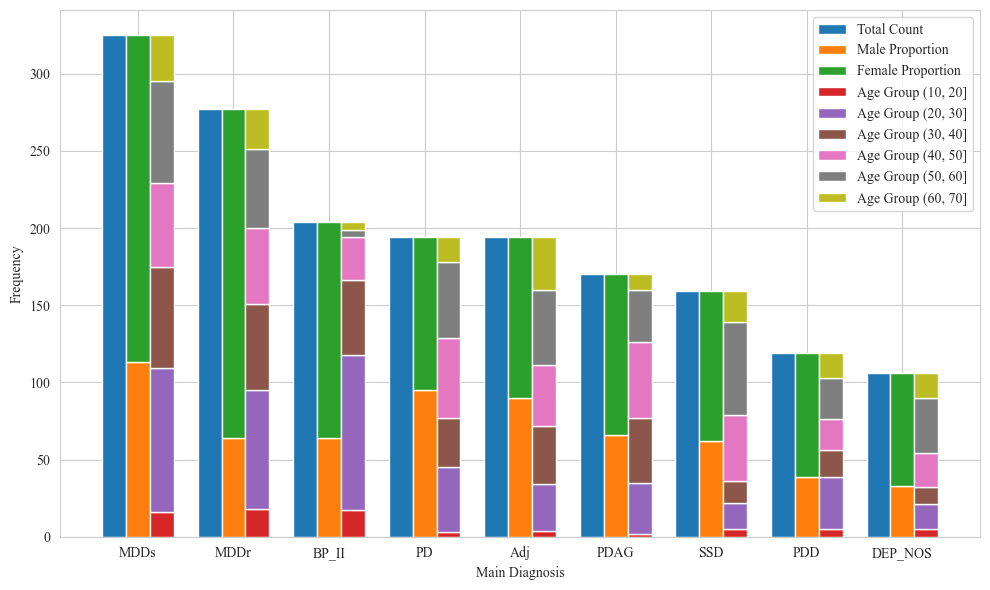

In [17]:
# main_dx별 개수 계산
main_dx_counts = data_ori['main_dx'].value_counts()

# main_dx별 성별 비율 계산 (성별이 'M'과 'F'로 나누어짐)
gender_counts = data_ori.groupby(['main_dx', 'gender']).size().unstack(fill_value=0)
gender_ratio = gender_counts.div(gender_counts.sum(axis=1), axis=0)

# main_dx별 연령대 비율 계산 (연령대별 비율 계산)
age_counts = data_ori.groupby(['main_dx', 'age_group']).size().unstack(fill_value=0)
age_ratio = age_counts.div(age_counts.sum(axis=1), axis=0)

# 그래프 크기 설정
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'Times New Roman'

# x 위치 설정 (막대의 중심이 각 main_dx에 맞도록)
x = range(len(main_dx_counts))

# main_dx의 개수에 대한 막대 그리기
bar_width = 0.25
plt.bar(x, main_dx_counts.values, width=bar_width, label='Total Count', align='center')

# 성별 비율에 대한 막대 그리기 (남성 비율, 여성 비율)
male_height = gender_ratio.loc[main_dx_counts.index, 'M'] * main_dx_counts.values
female_height = gender_ratio.loc[main_dx_counts.index, 'F'] * main_dx_counts.values
plt.bar([i + bar_width for i in x], male_height, width=bar_width, label='Male Proportion', align='center')
plt.bar([i + bar_width for i in x], female_height, bottom=male_height, width=bar_width, label='Female Proportion', align='center')

# 연령대 비율에 대한 막대 그리기 (각 연령대에 대해 표시)
age_bar_width = 0.25  # 연령대 막대 너비 설정
bottoms = 0

# 연령대별 막대 그리기
for i, age_group in enumerate(age_ratio.columns):
    age_height = age_ratio.loc[main_dx_counts.index, age_group] * main_dx_counts.values
    plt.bar([i + bar_width*2 for i in x], age_height, width=age_bar_width, label=f'Age Group {age_group}', align='center', bottom=bottoms)
    # 누적된 bottom 값 업데이트
    bottoms += age_height

# x축, y축, 레이블 설정
plt.xlabel('Main Diagnosis')
plt.ylabel('Frequency')

# x축의 main_dx 이름을 세 개의 막대 중앙에 맞추기
plt.xticks([i + bar_width for i in x], main_dx_counts.index, rotation=0)

# Legend 이름 변경
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()

### Hierarchical Imbalance Index (HII)

In [18]:
# 데이터셋이 준비되어 있다고 가정합니다
# data_ori는 이미 로드된 데이터프레임으로, target, gender, age_group 변수를 포함합니다

# 계층 목록
hierarchical_levels = ['main_dx', 'gender', 'age_group']

# HII 계산 함수
def calculate_hii(data, levels):
    total_classes = sum(data[level].nunique() for level in levels)  # 전체 클래스 수
    hii = 0  # 최종 HII 값 초기화

    # 각 계층에 대해 불균형도(IR)를 계산하고 가중치를 적용합니다.
    for level in levels:
        # 해당 계층의 클래스 빈도 계산
        class_counts = data[level].value_counts()
        max_class_count = class_counts.max()  # 계층 내 최대 클래스 빈도
        num_classes = len(class_counts)  # 해당 계층의 클래스 수

        # 계층 불균형도(IR) 계산
        ir = sum(abs(count - max_class_count) for count in class_counts) / (num_classes * max_class_count)
        print(ir)

        # 계층 가중치 계산
        weight = num_classes / total_classes

        # HII에 가중치와 불균형도를 반영하여 더함
        hii += weight * ir

    return hii

# HII 계산
hii_value = calculate_hii(data_ori, hierarchical_levels)
print("Hierarchical Imbalance Index (HII):", hii_value)

0.4023931623931624
0.22103386809269163
0.34236267870579384
Hierarchical Imbalance Index (HII): 0.3598695452916828


***

### Distribution check

In [ ]:
data_vis = data_ori.copy()
data_vis.head()

In [ ]:
info_ = ['sub', 'VISIT', 'age', 'gender', 'disorder_mdd']
# info_ = ['sub', 'VISIT', 'age', 'gender', 'disorder', 'disorder_mdd']
scale_ = ['HAMD', 'HAMA', 'PDSS', 'ASI', 'APPQ', 'PSWQ', 'SPI', 'PSS', 'BIS', 'SSI']
drop_ = info_ + scale_

In [ ]:
x_ = data_vis.drop(drop_, axis=1)

In [ ]:
x_.columns

#### KDE plot

In [ ]:
features = [col for col in list(x.columns)]

In [ ]:
def kdeplot_features(data, feature, title):
    
    df0 = data[data['disorder']=="mdd"]
    df1 = data[data['disorder']=="pd"]
    df2 = data[data['disorder']=="con"]

    df0 = df0.drop(['disorder'], axis=1)
    df1 = df1.drop(['disorder'], axis=1)
    df2 = df2.drop(['disorder'], axis=1)
    
    df0_values = df0[feature].to_numpy()
    df1_values = df1[feature].to_numpy()
    df2_values = df2[feature].to_numpy()
     
    plt.figure(figsize = (6, 2.5))
    
    sns.kdeplot(df0_values, color = 'y')
    sns.kdeplot(df1_values, color = 'b')
    sns.kdeplot(df2_values, color = 'g')
    
    plt.title(title, fontsize=15)
    plt.legend()
    plt.show();
    
    # del values_train , values_test
    # gc.collect()

In [ ]:
for var in features:
    kdeplot_features(x_, feature=var, title = var + "distribution")

#### JSD calculation

In [ ]:
## list to append distributional differences
variable = []
diff01 = []
diff02 = []
diff03 = []
diff12 = []
diff13 = []
diff23 = []

for feature in features:
    ## deleting any NA values in each feature column, for distance calculation
    data = data_vis.dropna(subset=[feature])

    ## split the dataset into each classes
    df0 = data[data['target_info']=="control"]
    df1 = data[data['target_info']=="mdd"]
    df2 = data[data['target_info']=="bpi"]
    df3 = data[data['target_info']=="bpii"]

    df0 = df0.drop(['target_info'], axis=1)
    df1 = df1.drop(['target_info'], axis=1)
    df2 = df2.drop(['target_info'], axis=1)
    df3 = df3.drop(['target_info'], axis=1)
    
    df0_values = df0[feature]
    df1_values = df1[feature]
    df2_values = df2[feature]
    df3_values = df3[feature]

    ## sampling based on the minimum size of the target info.
    sample_size = (min(df0_values.shape[0], df1_values.shape[0], df2_values.shape[0], df3_values.shape[0]))
    df0_sample = df0_values.sample(n=(sample_size))
    df1_sample = df1_values.sample(n=(sample_size))
    df2_sample = df2_values.sample(n=(sample_size))
    df3_sample = df3_values.sample(n=(sample_size))

    ## jensen-shannon divergence calculation and append
    variable.append(feature)
    diff01.append(jensenshannon(df0_sample, df1_sample))
    diff02.append(jensenshannon(df0_sample, df2_sample))
    diff03.append(jensenshannon(df0_sample, df3_sample))
    diff12.append(jensenshannon(df1_sample, df2_sample))
    diff13.append(jensenshannon(df1_sample, df3_sample))
    diff23.append(jensenshannon(df2_sample, df3_sample)) 

--------------

----------

# Data Augmentation

## dataset for model training

In [ ]:
data = data_ori.copy()

In [ ]:
data_CON = data[data['disorder']=="con"]
data_PD = data[data['disorder']=="pd"]
data_MDD = data[data['disorder']=="mdd"]

In [ ]:
data_vae = data.copy()
# data_vae = data_con.copy()
# data_vae = data_pd.copy()
# data_vae = data_mdd.copy()

## Variational Autoencoder (VAE)

In [ ]:
class Args_vae:
    # arugments
    epochs=150
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 2
    latent_dim = 2
    seed=710674

args_vae = Args_vae()

### preparing x, y dataset

In [ ]:
scale_list = ['HAMD', 'HAMA', 'PDSS', 'ASI', 'APPQ', 'PSWQ', 'SPI', 'PSS', 'BIS', 'SSI']
etc_list = ['sub', 'VISIT', 'disorder_mdd']
demo_list = ['age', 'gender', 'disorder']
drop_list = scale_list + etc_list + demo_list

In [ ]:
x = data.drop((drop_list), axis=1)
x = x.fillna(x.mean())
y = data.disorder# mdd / pd / con

In [ ]:
data_x = x.copy()
data_x[:] = (scaler.fit_transform(data_x[:])).round(decimals=6) ## scaling x values

label = y.copy()
label = label.replace({'mdd': 0})
label = label.replace({'pd': 1})
label = label.replace({'con' : 2})
data_y = to_categorical(label, 3) ## into the format of one-hot encoding

In [ ]:
print("The size of x dataset is:", data_x.shape)
print("The size of y dataset is:", data_y.shape)

***

### vae model

In [ ]:
class VAE:
    def __init__(self, input_dim, latent_dim):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.encoder = None
        self.decoder = None
        self.vae = None
        self.build_model()

    ## VAE model for data augmentation
    def build_model(self):
        ####################################################
        ## defining encoder section
        inputs = Input(shape=(self.input_dim,))
        
        # shallow model use
        h = Dense(32, activation='relu')(inputs)

        # # deeper model use
        # h = Dense(128, activation='relu')(inputs)
        # h = Dense(64, activation='relu')(h)
        # h = Dense(32, activation='relu')(h)

        # calculating mean/var
        z_mean = Dense(self.latent_dim)(h)
        z_log_var = Dense(self.latent_dim)(h)

        ## sampling section (for gaussian distribution)
        def sampling(args):
            z_mean, z_log_var = args
            batch = K.shape(z_mean)[0]
            dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon

        z = Lambda(sampling, output_shape=(self.latent_dim,))([z_mean, z_log_var])

        ####################################################
        ## defining decoder section

        # shallower model use
        decoder_h = Dense(32, activation='relu')
        decoder_mean = Dense(self.input_dim, activation='sigmoid')
        h_decoded = decoder_h(z)
        x_decoded_mean = decoder_mean(h_decoded)
        
        # # deeper model use
        # decoder_h1 = Dense(32, activation='relu')
        # decoder_h2 = Dense(64, activation='relu')
        # decoder_h3 = Dense(128, activation='relu')
        # decoder_mean = Dense(self.input_dim, activation='sigmoid')

        # h_decoded = decoder_h1(z)
        # h_decoded = decoder_h2(h_decoded)
        # h_decoded = decoder_h3(h_decoded)
        # x_decoded_mean = decoder_mean(h_decoded)

        ####################################################
        ## defining VAE model
        self.vae = Model(inputs, x_decoded_mean)

        ####################################################
        ## defining loss function (reconstruction + KL divergence)
        reconstruction_loss = MeanSquaredError()(inputs, x_decoded_mean)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var + K.epsilon()), axis=-1)
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        self.vae.add_loss(vae_loss)

        ####################################################
        ## compiling model
        self.vae.compile(optimizer=Adam(learning_rate=0.001))

        ####################################################
        ## Extracting encoder and decoder separately
        ## encoder section
        self.encoder = Model(inputs, z_mean)

        ## decoder section
        decoder_input = Input(shape=(self.latent_dim,))
        _h_decoded = decoder_h(decoder_input)
        _x_decoded_mean = decoder_mean(_h_decoded)
        self.decoder = Model(decoder_input, _x_decoded_mean)
        
        # #### deeper model
        # decoder_input = Input(shape=(self.latent_dim,))
        # _h_decoded = decoder_h1(decoder_input)
        # _h_decoded = decoder_h2(_h_decoded)
        # _h_decoded = decoder_h3(_h_decoded)
        # _x_decoded_mean = decoder_mean(_h_decoded)
        # self.decoder = Model(decoder_input, _x_decoded_mean)
    
    ####################################################
    ####################################################
    ## Model training
    def train(self, data, epochs, batch_size, validation_split):
        self.vae.fit(data, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

    def encode(self, data):
        return self.encoder.predict(data)

    def decode(self, latent_points):
        return self.decoder.predict(latent_points)

    def generate_synthetic_data(self, num_samples=1):
        latent_samples = np.random.normal(size=(num_samples, self.latent_dim)) ## sampling from latent space
        return self.decode(latent_samples) ## synthetic data generation with decoder section

    def visualize_latent_space(self, data, labels):
        ## encode the dataset into latent space
        encoded_data = self.encode(data)

        ## latent space visualization with t-SNE
        tsne = TSNE(n_components=2, random_state=710674)
        encoded_data_tsne = tsne.fit_transform(encoded_data)

        ## Visualize
        plt.figure(figsize=(8, 6))
        plt.scatter(encoded_data_tsne[:, 0], encoded_data_tsne[:, 1], c=labels, cmap='viridis')
        plt.colorbar()
        plt.xlabel("t-SNE component 1")
        plt.ylabel("t-SNE component 2")
        plt.title("t-SNE visualization of the latent space")
        plt.show()

In [ ]:
vae = VAE(input_dim=data_x.shape[1], latent_dim=args_vae.latent_dim)
vae.train(data_x, epochs = args_vae.epochs, batch_size = args_vae.bs, validation_split=0.2)

### Latent space visualization

In [ ]:
vae.visualize_latent_space(data_x, label)

***

### Synthetic data generation

> We use two different synthetic data generation functions.
> 1. Adopting single VAE model(trained on all data classes)
> 2. Adopting individual VAE model for each data classes. 

#### single VAE model

In [ ]:
data_ori['disorder'].value_counts()

In [ ]:
def generate_synthetic_data_for_classes(vae_model, latent_dim, class_labels, num_samples_per_class):
    synthetic_data = {}
    for class_label in class_labels:
        num_samples = num_samples_per_class[class_label]
        ## sampling from latent space
        z_samples = np.random.normal(size=(num_samples, latent_dim))
        ## use sampled data to generate synthetic dataset
        generated_samples = vae_model.decoder.predict(z_samples)
        ## save synthetic dataset with class label
        synthetic_data[class_label] = generated_samples
    return synthetic_data

In [ ]:
# 생성할 클래스 라벨들과 각 클래스별 생성할 샘플 수
num_samples_per_class = {0:164, 1:151, 2: 106} ##Set to total 300 for each class

# 각 클래스별 synthetic data 생성
synthetic_data = generate_synthetic_data_for_classes(vae, args_vae.latent_dim, label, num_samples_per_class)

In [ ]:
# 각 클래스에 대한 데이터프레임화
gen_mdd = pd.DataFrame(synthetic_data[0], columns=data_x.columns)
gen_pd = pd.DataFrame(synthetic_data[1], columns=data_x.columns)
gen_con = pd.DataFrame(synthetic_data[2], columns=data_x.columns)
print(f"The synthetic data size is... \n\nSynthetic for MDD class: {gen_mdd.shape[0]} \nSynthetic for PD class: {gen_pd.shape[0]} \nSynthetic for control class: {gen_con.shape[0]}")

> now move to "Classification performance check - Augmented datasets add"

***

#### individual VAE model

In [ ]:
def generate_class_synthetic_data_vae(vae_model, latent_dim, num_samples):
    ## sampling from latent space
    z_samples = np.random.normal(size=(num_samples, latent_dim))
    ## use sampled latent space vector to generate synthetic dataset
    synthetic_data = vae_model.decoder.predict(z_samples)
    return synthetic_data

In [ ]:
data_mdd, data_pd, data_con = (data_MDD.drop(drop_list, axis=1), data_PD.drop(drop_list, axis=1), data_CON.drop(drop_list, axis=1))

data_mdd[:] = (scaler.fit_transform(data_mdd[:])).round(decimals=6)
data_pd[:] = (scaler.fit_transform(data_pd[:])).round(decimals=6)
data_con[:] = (scaler.fit_transform(data_con[:])).round(decimals=6)

In [ ]:
# MDD 클래스에 대한 VAE 모델 학습
vae_mdd = VAE(data_mdd.shape[1], latent_dim = args_vae.latent_dim)
vae_mdd.train(data_mdd, epochs=args_vae.epochs, batch_size=args_vae.bs, validation_split=0.2)

# PD 클래스에 대한 VAE 모델 학습
vae_pd = VAE(data_pd.shape[1], latent_dim = args_vae.latent_dim)
vae_pd.train(data_pd, epochs=args_vae.epochs, batch_size=args_vae.bs, validation_split=0.2)

# Control 클래스에 대한 VAE 모델 학습
vae_con = VAE(data_con.shape[1], latent_dim = args_vae.latent_dim)
vae_con.train(data_con, epochs=args_vae.epochs, batch_size=args_vae.bs, validation_split=0.2)

In [ ]:
num_samples_per_class = {0:164, 1:151, 2: 106}

num_samples_mdd = num_samples_per_class[0]
synthetic_data_mdd = generate_class_synthetic_data_vae(vae_mdd, args_vae.latent_dim, num_samples_mdd)

num_samples_pd = num_samples_per_class[1]
synthetic_data_pd = generate_class_synthetic_data_vae(vae_pd, args_vae.latent_dim, num_samples_pd)

num_samples_con = num_samples_per_class[2]
synthetic_data_con = generate_class_synthetic_data_vae(vae_con, args_vae.latent_dim, num_samples_con)

In [ ]:
## transform into the dataframe format
gen_mdd = pd.DataFrame(synthetic_data_mdd, columns=data_x.columns)
gen_pd = pd.DataFrame(synthetic_data_pd, columns=data_x.columns)
gen_con = pd.DataFrame(synthetic_data_con, columns=data_x.columns)

> now move to "Classification performance check - Augmented datasets add"

***

***

## Conditional VAE model

In [ ]:
class Args_cvae:
    # arugments
    epochs=150
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 3
    latent_dim = 2
    seed=710674

args_cvae = Args_cvae()

> preparing x, y dataset

In [ ]:
data_cvae = data_ori.copy()

In [ ]:
## relabeling data_cvae's disorder variable to use them as an conditional input
data_cvae['disorder'] = data_cvae['disorder'].replace({'mdd': 0})
data_cvae['disorder'] = data_cvae['disorder'].replace({'pd' : 1})
data_cvae['disorder'] = data_cvae['disorder'].replace({'con': 2})

In [ ]:
scale_list = ['HAMD', 'HAMA', 'PDSS', 'ASI', 'APPQ', 'PSWQ', 'SPI', 'PSS', 'BIS', 'SSI']
etc_list = ['sub', 'VISIT', 'disorder_mdd']
demo_list = ['age', 'gender', 'disorder']
drop_list = scale_list + etc_list + demo_list

In [ ]:
## x: input, y: output, c: conditional inputs
x = data_cvae.drop(drop_list, axis=1)
x = x.fillna(x.mean())
y = data_cvae.disorder
c = data_cvae.loc[:, ('age', 'gender', 'disorder')]

In [ ]:
data_x = x.copy()
data_x[:] = (scaler.fit_transform(data_x[:])).round(decimals=6)
###################
label = y.copy()
data_y = to_categorical(label, 3) ## into the format of one-hot encoding
###################
data_c = c.copy()
data_c[:] = (scaler.fit_transform(data_c[:])).round(decimals=6)

In [ ]:
print("The size of x dataset is:", data_x.shape)
print("The size of y dataset is:", data_y.shape)
print("The size of c dataset is:", data_c.shape)

> CVAE model preparation

In [ ]:
class CVAE:
    def __init__(self, input_dim, condition_dim, latent_dim):
        ## initializing model
        self.input_dim = input_dim
        self.condition_dim = condition_dim
        self.latent_dim = latent_dim
        
        ## generating encoder and decoder section
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.cvae = self.build_cvae()
    
    ## defining encoder function
    def build_encoder(self):
        x_input = layers.Input(shape=(self.input_dim,), name='input')
        c_input = layers.Input(shape=(self.condition_dim,), name='condition')
        
        ## defining input layer: put x and condition c together
        combined_input = layers.Concatenate()([x_input, c_input])
        
        # encoder layers defining
        h = layers.Dense(64, activation=None)(combined_input)
        h = layers.BatchNormalization()(h)
        h = layers.Activation('relu')(h)
        h = layers.Dropout(0.3)(h)
        
        h = layers.Dense(32, activation=None)(h)
        h = layers.BatchNormalization()(h)
        h = layers.Activation('relu')(h)
        h = layers.Dropout(0.3)(h)
        
        z_mean = layers.Dense(self.latent_dim, name='z_mean')(h)
        z_log_var = layers.Dense(self.latent_dim, name='z_log_var')(h)
        
        ## sampling (reparameterization)
        def sampling(args):
            z_mean, z_log_var = args
            batch = K.shape(z_mean)[0]
            dim = K.int_shape(z_mean)[1]
            epsilon = K.random_normal(shape=(batch, dim))
            return z_mean + K.exp(0.5 * z_log_var) * epsilon
        
        z = layers.Lambda(sampling, output_shape=(self.latent_dim,), name='z')([z_mean, z_log_var])
        
        return Model([x_input, c_input], [z_mean, z_log_var, z], name='encoder')
    
    ## defining decoder function
    def build_decoder(self):
        z_input = layers.Input(shape=(self.latent_dim,), name='z_sampling')
        c_input = layers.Input(shape=(self.condition_dim,), name='condition')
        
        ## decoder input defining: put latent space input and conditional c together
        combined_input = layers.Concatenate()([z_input, c_input])

        # decoder layers defining
        h = layers.Dense(32, activation=None)(combined_input)
        h = layers.BatchNormalization()(h)
        h = layers.Activation('relu')(h)
        h = layers.Dropout(0.3)(h)  # Dropout with 30% rate
        
        h = layers.Dense(64, activation=None)(h)
        h = layers.BatchNormalization()(h)
        h = layers.Activation('relu')(h)
        h = layers.Dropout(0.3)(h)  # Dropout with 30% rate
        
        x_decoded = layers.Dense(self.input_dim, activation='sigmoid', name='output')(h)
        
        return Model([z_input, c_input], x_decoded, name='decoder')
    
    ## build and compile the CVAE model
    def build_cvae(self):
        x_input = layers.Input(shape=(self.input_dim,), name='input')
        c_input = layers.Input(shape=(self.condition_dim,), name='condition')
        
        z_mean, z_log_var, z = self.encoder([x_input, c_input])
        x_decoded = self.decoder([z, c_input])
        
        cvae = Model([x_input, c_input], x_decoded, name='cvae')
        
        reconstruction_loss = mse(x_input, x_decoded)
        reconstruction_loss *= self.input_dim
        
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        
        cvae_loss = K.mean(reconstruction_loss + kl_loss)
        cvae.add_loss(cvae_loss)
        cvae.compile(optimizer='adam')
        
        return cvae
    
    def encode(self, data, condition):
        z_mean, z_log_var, z = self.encoder.predict([data, condition])
        return z_mean, z_log_var, z

    def decode(self, latent, condition):
        return self.decoder.predict([latent, condition])
    
    ## model training
    def train(self, x_train, c_train, epochs, batch_size, validation_split=None):
        self.cvae.fit([x_train, c_train], epochs=epochs, batch_size=batch_size, validation_split=validation_split)
    
    ## synthetic data generation (for data augmentation)
    def generate_synthetic_data(self, condition, n_samples):
        z_samples = np.random.normal(size=(n_samples, self.latent_dim))
        synthetic_data = self.decoder.predict([z_samples, condition])
        return synthetic_data


    def visualize_latent_space(self, x_data, c_data, labels, n_samples):
        c_data = np.array(data_c)
        n_samples = min(n_samples, len(x_data), len(c_data))
        indices = np.random.choice(len(x_data), n_samples, replace=False) ## data sampling for n
        x_sample = x_data.iloc[indices]
        c_sample = c_data[indices]
        z_mean, _, _ = self.encoder.predict([x_sample, c_sample]) ## calculating latent vector z
        tsne = TSNE(n_components=2, random_state=710674) #tsne visualization
        z_tsne = tsne.fit_transform(z_mean)

        ## visualization
        plt.figure(figsize=(8, 6))
        if labels is not None:
            plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=labels[indices], cmap='viridis')
            plt.colorbar()
        else:
            plt.scatter(z_tsne[:, 0], z_tsne[:, 1])
        plt.title('t-SNE visualization of the latent space')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.show()

In [ ]:
cvae = CVAE(input_dim = data_x.shape[1], condition_dim = data_c.shape[1], latent_dim=args_cvae.latent_dim)
cvae.train(data_x, data_c, epochs=args_cvae.epochs, batch_size=args_cvae.bs, validation_split=0.2)

> Latent space visualization

In [ ]:
cvae.visualize_latent_space(data_x, data_c, label, n_samples=500)

***

> Synthetic data generation

In [ ]:
label.value_counts()

#### Using single CVAE model (integrated)

In [ ]:
def generate_class_synthetic_data(cvae_model, c_data, n_samples_per_class, labels, method):
    synthetic_data = {}
    new_conditions = {}

    for class_label, n_samples in n_samples_per_class.items():
        ## filtering the condition for each class
        class_indices = labels == class_label
        class_conditions = c_data[class_indices]
        
        if class_conditions.empty:
            print(f"Warning: No data found for class label {class_label}. Skipping this class.")
            continue
        
        ## generating new condition for conditional VAE data augmentation
        ## randomly sampling from the original condition dataset
        if method == 'random':
            class_new_conditions = class_conditions.sample(n=n_samples, replace=True).values
        ## calculate mean and variance from original condition dataset to sampling
        elif method == 'gaussian':
            mean = class_conditions.mean(axis=0).values
            std = class_conditions.std(axis=0).values
            class_new_conditions = np.random.normal(loc=mean, scale=std, size=(n_samples, class_conditions.shape[1]))
        
        ## generate synthetic dataset for each class with new conditions
        class_synthetic_data = cvae_model.generate_synthetic_data(class_new_conditions, n_samples=n_samples)
        
        ## save the synthesized results
        synthetic_data[class_label] = class_synthetic_data
        new_conditions[class_label] = class_new_conditions
    
    return synthetic_data

In [ ]:
n_samples_per_class = {0:164, 1:151, 2: 106}
## synthetic data generation (augmentation)
# synthetic_data = generate_class_synthetic_data(cvae, data_c, n_samples_per_class, label, method='random')
synthetic_data = generate_class_synthetic_data(cvae, data_c, n_samples_per_class, label, method='gaussian')

# print("\n=====================================")
# print("Class 0(MDD) - Generated Synthetic Data: ")
# print(synthetic_data[0])
# print("\n=====================================")
# print("\nClass 1(PD) - Generated Synthetic Data:")
# print(synthetic_data[1])
# print("\n=====================================")
# print("\nClass 1(CON) - Generated Synthetic Data:")
# print(synthetic_data[2])

In [ ]:
## transform into the dataframe format
gen_mdd = pd.DataFrame(synthetic_data[0], columns=data_x.columns)
gen_pd = pd.DataFrame(synthetic_data[1], columns=data_x.columns)
gen_con = pd.DataFrame(synthetic_data[2], columns=data_x.columns)

=====================================================

#### Using individual CVAE model

In [ ]:
## we should train individual CVAE model for each class
cvae_models = {}

for class_label in np.unique(label):
    ## data filtering to find dataset with that class label
    class_indices = np.where(label == class_label)[0]
    class_data = data_x.iloc[class_indices]
    
    ## initialize and train CVAE model
    cvae = CVAE(input_dim=data_x.shape[1], latent_dim=args_cvae.latent_dim, condition_dim=data_y.shape[1])
    cvae.train(class_data, data_y[class_indices], epochs=args_cvae.epochs, batch_size=args_cvae.bs, validation_split=0.2)
    
    ## save the trained model
    cvae_models[class_label] = cvae

In [ ]:
def generate_class_synthetic_data_seperately(cvae_models, c_data, n_samples_per_class, labels, method):
    synthetic_data = {}
    new_conditions = {}

    for class_label, n_samples in n_samples_per_class.items():
        ## loading trained CVAE model for each class
        cvae_model = cvae_models[class_label]
        
        ## filtering the condition for the class
        class_indices = labels == class_label
        class_conditions = c_data[class_indices]

        ## generating new condition for conditional VAE data augmentation
        ## randomly sampling from the original condition dataset
        if method == 'random':
            class_new_conditions = class_conditions.sample(n=n_samples, replace=True).values
        ## calculate mean and variance from origianl condition dataset to sampling
        elif method == 'gaussian':
            mean = class_conditions.mean(axis=0).values
            std = class_conditions.std(axis=0).values
            class_new_conditions = np.random.normal(loc=mean, scale=std, size=(n_samples, class_conditions.shape[1]))
        
        ## generate synthetic dataset for each class with new conditions
        class_synthetic_data = cvae_model.generate_synthetic_data(class_new_conditions, n_samples=n_samples)
        
        ## save the synthesized results
        synthetic_data[class_label] = class_synthetic_data
        new_conditions[class_label] = class_new_conditions
    
    # return synthetic_data, new_conditions
    return synthetic_data

In [ ]:
n_samples_per_class = {0:164, 1:151, 2: 106}

synthetic_data = generate_class_synthetic_data_seperately(cvae_models, data_c, n_samples_per_class, label, method="random")
# synthetic_data = generate_class_synthetic_data_seperately(cvae_models, data_c, n_samples_per_class, label, method="gaussian")

# print("\n=====================================")
# print("Class 0(MDD) - Generated Synthetic Data: ")
# print(synthetic_data[0])
# print("\n=====================================")
# print("\nClass 1(PD) - Generated Synthetic Data:")
# print(synthetic_data[1])
# print("\n=====================================")
# print("\nClass 1(CON) - Generated Synthetic Data:")
# print(synthetic_data[2])

In [ ]:
## transform into the dataframe format
gen_mdd = pd.DataFrame(synthetic_data[0], columns=data_x.columns)
gen_pd = pd.DataFrame(synthetic_data[1], columns=data_x.columns)
gen_con = pd.DataFrame(synthetic_data[2], columns=data_x.columns)

-=-=-=-=-=-=

> Reconstruct original dataset using trained model to adopt augmented trainig dataset?

In [ ]:
z_mean, z_log_var, z_latent = cvae.encode(data_x, data_c)

In [ ]:
reconstructed_data = cvae.decode(z_latent, data_c)

In [ ]:
reconstructed_data

In [ ]:
data_x

In [ ]:
gen_mdd

-=-=-=-=-=-=

----------

-----------

## Latent Diffusion Model

In [ ]:
class Args_diffusion:
    # arugments
    epochs=80
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 3
    latent_dim = 4
    seed=710674

args_diffusion = Args_diffusion()

* preparing x, y dataset

In [ ]:
data_diffusion = data_ori.copy()

In [ ]:
data_CON = data_diffusion[data_diffusion['disorder']=="con"]
data_PD = data_diffusion[data_diffusion['disorder']=="pd"]
data_MDD = data_diffusion[data_diffusion['disorder']=="mdd"]

In [ ]:
scale_list = ['HAMD', 'HAMA', 'PDSS', 'ASI', 'APPQ', 'PSWQ', 'SPI', 'PSS', 'BIS', 'SSI']
etc_list = ['sub', 'VISIT', 'disorder_mdd']
demo_list = ['age', 'gender', 'disorder']
drop_list = scale_list + etc_list + demo_list

In [ ]:
x = data_diffusion.drop((drop_list), axis=1)
x = x.fillna(x.mean())
y = data_diffusion.disorder# mdd / pd / con

In [ ]:
data_x = x.copy()
data_x[:] = (scaler.fit_transform(data_x[:])).round(decimals=6) ## scaling x values

label = y.copy()
label = label.replace({'mdd': 0})
label = label.replace({'pd': 1})
label = label.replace({'con' : 2})
data_y = to_categorical(label, 3) ## into the format of one-hot encoding

In [ ]:
print("The size of x dataset is:", data_x.shape)
print("The size of y dataset is:", data_y.shape)

* 1 Dimensional latent diffusion model

In [ ]:
class LatentDiffusionVAE:
    def __init__(self, input_shape, latent_dim):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.vae = self.build_vae()
        
    ## sampling - reparameterization
    def sampling(self, repara):
        z_mean, z_log_var = repara
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def build_encoder(self):
        inputs = Input(shape=self.input_shape)
        x = layers.Conv1D(32, 3, activation='relu', padding='same')(inputs)
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation='relu')(x)
        z_mean = layers.Dense(self.latent_dim)(x)
        z_log_var = layers.Dense(self.latent_dim)(x)
        return Model(inputs, [z_mean, z_log_var], name='encoder')

    def build_decoder(self):
        latent_inputs = Input(shape=(self.latent_dim,))
        x = layers.Dense(128, activation='relu')(latent_inputs)
        x = layers.Dense(np.prod(self.input_shape), activation='relu')(x)
        x = layers.Reshape(self.input_shape)(x)
        outputs = layers.Conv1D(1, 3, activation='sigmoid', padding='same')(x)
        return Model(latent_inputs, outputs, name='decoder')

    def build_vae(self):
        inputs = Input(shape=self.input_shape)
        z_mean, z_log_var = self.encoder(inputs)
        z = layers.Lambda(self.sampling, output_shape=(self.latent_dim,))([z_mean, z_log_var])
        outputs = self.decoder(z)

        vae = Model(inputs, outputs, name='vae')

        # Define the VAE loss
        reconstruction_loss = MeanSquaredError()(inputs, outputs)
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        vae_loss = reconstruction_loss + kl_loss
        vae.add_loss(vae_loss)
        vae.compile(optimizer='adam')

        return vae

    def train(self, data_x, epochs, batch_size, validation_split=0.2, verbose=2):
        self.vae.fit(data_x, epochs=epochs, validation_split=validation_split, batch_size=batch_size, verbose=verbose)

    def generate(self, latent_sample):
        return self.decoder.predict(latent_sample)


# Example usage:
# Assuming data_x and args_diffusion are already defined

input_shape = (data_x.shape[1], 1)
latent_dim = args_diffusion.latent_dim

vae_model = LatentDiffusionVAE(input_shape, latent_dim)
vae_model.train(data_x, epochs=args_diffusion.epochs, batch_size=args_diffusion.bs)

--- working code (start) --- 

In [ ]:
# Sampling function for the latent space
def sampling(repara):
    z_mean, z_log_var = repara
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define encoder
def build_encoder(input_shape, latent_dim):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 3, activation='relu', padding='same')(inputs)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    return Model(inputs, [z_mean, z_log_var], name='encoder')

# Define decoder
def build_decoder(output_shape, latent_dim):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(128, activation='relu')(latent_inputs)
    x = Dense(np.prod(output_shape), activation='relu')(x)
    x = Reshape(output_shape)(x)
    outputs = Conv1D(1, 3, activation='sigmoid', padding='same')(x)
    return Model(latent_inputs, outputs, name='decoder')

In [ ]:
input_shape = (data_x.shape[1], 1)  # Example input shape
latent_dim = args_diffusion.latent_dim

In [ ]:
## Define the VAE
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(input_shape, latent_dim)

inputs = Input(shape=input_shape)
z_mean, z_log_var = encoder(inputs)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
outputs = decoder(z)

vae = Model(inputs, outputs, name='vae')

# Define the VAE loss
reconstruction_loss = MeanSquaredError()(inputs, outputs)
kl_loss = -0.5 * tf.reduce_mean(
    z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
vae_loss = reconstruction_loss + kl_loss
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# vae.summary()

* model training

In [ ]:
# Train the VAE
vae.fit(data_x, epochs=args_diffusion.epochs, validation_split=0.2, batch_size=args_diffusion.bs, verbose=2)

--- working code (end) ---

***

---------

-----------

# Classification performance check

## Original dataset only

In [78]:
data_dnn = df.copy()

In [79]:
data_dnn.main_dx.value_counts()

main_dx
MDDs       325
MDDr       277
BP_II      204
PD         194
Adj        194
PDAG       170
SSD        159
PDD        119
DEP_NOS    106
Name: count, dtype: int64

In [80]:
data_dnn.shape

(1748, 18)

In [81]:
data_dnn['psi'] = pd.to_numeric(data_dnn['psi'], errors='coerce')

In [82]:
x = data_dnn.drop(['main_dx'], axis=1)
x = x.fillna(x.mean())
y = data_dnn.main_dx

In [83]:
x.columns

Index(['sdnn', 'psi', 'tp', 'vlf', 'lf', 'hf', 'lfnorm', 'hfnorm', 'lf_hf',
       'rmssd', 'apen', 'srd', 'tsrd', 'tp_ln', 'vlf_ln', 'lf_ln', 'hf_ln'],
      dtype='object')

In [84]:
y.value_counts()

main_dx
MDDs       325
MDDr       277
BP_II      204
PD         194
Adj        194
PDAG       170
SSD        159
PDD        119
DEP_NOS    106
Name: count, dtype: int64

In [85]:
data_x = x.copy()
data_x[:] = (scaler.fit_transform(data_x[:])).round(decimals=6) ## scaling x values

label, uniques = pd.factorize(y)  # y를 숫자로 변환
data_y = to_categorical(label, len(uniques))  # 원-핫 인코딩

In [86]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state = 710674)

In [87]:
## definition for computing class weight (to solve class imbalance issue)
def compute_class_weights(y):
    class_counts = np.bincount(y) ## calculating data point for each class
    total_samples = len(y) ## total data points
    ## computing each class weight
    class_weights = {i: total_samples / (len(class_counts) * class_count) 
                     for i, class_count in enumerate(class_counts)}
    
    return class_weights

In [88]:
cla = len(uniques)

In [89]:
class_weight = compute_class_weights(label)
print(class_weight)

{0: 1.2215234102026555, 1: 0.9520697167755992, 2: 1.6321195144724556, 3: 1.0011454753722795, 4: 1.8322851153039832, 5: 1.142483660130719, 6: 1.0011454753722795, 7: 0.7011632571199358, 8: 0.5976068376068376}


***

## Augmented dataset add

> we generate synthesized dataset using VAE from above. \
> adopted original datset: data_mdd, data_bpi, data_bpii \
> synthesized into: gen_mdd, gen_bpi, gen_bpii \
> gen_control is not generated since "control group" has biggest number.

In [ ]:
class synthetic_data_preparation:
    def __init__(self, original_data, gen_data, label_col, id_cols=None, drop_cols=None):
        """
        original_data (pandas.DataFrame): original dataset
        gen_data (dict): data dictionary for synthetic dataset (ex: {0: gen_A, 1: gen_B})
        label_col (str): label column (target variable)
        id_cols (list): column list to drop (예: ['Unnamed: 32', 'id'])
        drop_cols (list): column list to drop from original dataset
        """
        self.original_data = original_data
        self.gen_data = gen_data
        self.label_col = label_col
        self.id_cols = id_cols if id_cols is not None else []
        self.drop_cols = drop_cols if drop_cols is not None else []
        
    def prepare_data(self):
        ## preprocessing original dataset
        data_dnn = self.original_data.copy()
        for col in self.id_cols:
            if col in data_dnn.columns:
                data_dnn = data_dnn.drop(col, axis=1)
        
        data_dnn = data_dnn.drop(self.drop_cols, axis=1)
        data_classes = {label: data_dnn[data_dnn[self.label_col] == label] for label in data_dnn[self.label_col].unique()}
        
        ## preprocessing synthetic generated dataset
        for label, df in self.gen_data.items():
            df[self.label_col] = label
            if self.drop_cols:
                df = df.drop(self.drop_cols, axis=1)
            self.gen_data[label] = df
        
        ## concat original dataset and generated dataset
        ori_df_concat = pd.concat(list(data_classes.values()), ignore_index=True)
        gen_df_concat = pd.concat(list(self.gen_data.values()), ignore_index=True)
        
        ## separating feature and label(target)
        ori_x = ori_df_concat.drop([self.label_col], axis=1)
        ori_y = ori_df_concat[[self.label_col]]
        
        gen_x = gen_df_concat.drop([self.label_col], axis=1)
        gen_y = gen_df_concat[[self.label_col]]
        
        ## filling missing values and scaling
        ori_x = ori_x.fillna(ori_x.mean())
        ori_x[:] = (scaler.fit_transform(ori_x[:])).round(decimals=6) ## scaling x values
        
        # 레이블 인코딩 및 원-핫 인코딩
        ori_y = ori_y.replace({self.label_col: {label: idx for idx, label in enumerate(ori_y[self.label_col].unique())}})
        y_ori = to_categorical(ori_y, num_classes=len(ori_y[self.label_col].unique()))
        
        gen_y = gen_y.replace({self.label_col: {label: idx for idx, label in enumerate(gen_y[self.label_col].unique())}})
        y_gen = to_categorical(gen_y, num_classes=len(gen_y[self.label_col].unique()))
        
        ## separating training and test dataset
        x_trainset, x_test, y_trainset, y_test = train_test_split(ori_x, y_ori, test_size=0.35, random_state=710674)
        
        ## add generated dataset to training dataset
        x_train_concat = pd.concat([x_trainset, gen_x], ignore_index=True)
        y_train_concat = np.concatenate([y_trainset, y_gen])
        
        ## separating training dataset and validation dataset
        x_train, x_vali, y_train, y_vali = train_test_split(x_train_concat, y_train_concat, test_size=0.2, random_state=710674)
        
        return x_train, x_vali, x_test, y_train, y_vali, y_test

In [ ]:
data_ori.columns

In [ ]:
scale_list_ = ['HAMD', 'HAMA', 'PDSS', 'ASI', 'APPQ', 'PSWQ', 'SPI', 'PSS', 'BIS', 'SSI']
etc_list_ = ['sub', 'VISIT', 'disorder_mdd']
demo_list_ = ['age', 'gender']
drop_list_ = scale_list_ + etc_list_ + demo_list_

In [ ]:
## make a dictionary for generated dataset
gen_data = {"mdd":gen_mdd, "pd":gen_pd, "con":gen_con}

## data_preparation class initialize and data prepare
data_prep = synthetic_data_preparation(data_ori, gen_data, label_col='disorder', id_cols=drop_list_)
x_train, x_vali, x_test, y_train, y_vali, y_test = data_prep.prepare_data()

***

***

## Simple DNN

In [90]:
class Args_dnn:
    # arugments
    epochs=50
    bs=16
    lr=0.001
    momentum=0.9
    num_classes= cla
    seed=710674

args_dnn = Args_dnn()

* DNN model

In [91]:
class SimpleDNN:
    def __init__(self, input_dim, layer_configs, output_units, output_activation='softmax'):
        self.input_dim = input_dim ## input data dimensionality (# variables)
        self.layer_configs = layer_configs ## hidden layer/sequential layer lists (units, activation, batch_norm, dropout_rate)
        self.output_units = output_units ## output unit no.
        self.output_activation = output_activation ## activation function for output layer
        self.model = self.build_model()
        self.callbacks = []

    def build_model(self):
        model = models.Sequential()
        ## add first hidden layer
        model.add(layers.Dense(units=self.layer_configs[0]['units'], activation=self.layer_configs[0]['activation'], input_shape=(self.input_dim,)))
        
        ## batch normalization and dropout for first layer
        if self.layer_configs[0].get('batch_norm', False):
            model.add(layers.BatchNormalization())
        if self.layer_configs[0].get('dropout_rate', None) is not None:
            model.add(layers.Dropout(rate=self.layer_configs[0]['dropout_rate']))
        
        ## do same for rest hidden layers (except for the last)
        for config in self.layer_configs[1:]:
            model.add(layers.Dense(units=config['units'], activation=config['activation']))
            
            if config.get('batch_norm', False):
                model.add(layers.BatchNormalization())
            
            if config.get('dropout_rate', None) is not None:
                model.add(layers.Dropout(rate=config['dropout_rate']))
        
        ## add output layer
        model.add(layers.Dense(units=self.output_units, activation=self.output_activation))
        
        return model

    def compile_model(self, optimizer, loss='categorical_crossentropy', metrics=['accuracy'], lr_scheduler=None):
        if lr_scheduler:
            ## AddLearningRateScheduler callback
            self.callbacks.append(LearningRateScheduler(lr_scheduler))
        
        self.model.compile(optimizer, loss, metrics)

    def fit_model(self, x_train, y_train, epochs, batch_size, validation_split=None, class_weight=None, validation_data=None):
        return self.model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
                             class_weight=class_weight, validation_data = validation_data, callbacks=self.callbacks)

    def evaluate_model(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        return self.model.predict(x)

    def summary(self):
        self.model.summary()

* optimization function, model compile, and model training

In [92]:
def dynamic_learning_rate(epoch, mode='cyclic', base_lr=0.001, max_lr=0.006, step_size=2000, gamma=0.99994):
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    
    if mode == 'cyclic' or mode == 'triangular':
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    elif mode == 'triangular2':
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x)) / (2 ** (cycle - 1))
    elif mode == 'exp_range':
        lr = base_lr + (max_lr - base_lr) * max(0, (1 - x)) * (gamma ** epoch)
    else:
        raise ValueError("Invalid mode. Choose from 'cyclic', 'triangular', 'triangular2', or 'exp_range'.")
    
    return lr

In [93]:
# lr = dynamic_learning_rate(epoch=1000, mode='cyclic')
# lr = dynamic_learning_rate(epoch=1000, mode='triangular')
# lr = dynamic_learning_rate(epoch=1000, mode='triangular2')
# lr = dynamic_learning_rate(epoch=1000, mode='exp_range', gamma=0.99994)

In [94]:
x.shape

(1748, 17)

In [95]:
## model initialization with hidden layer list below
layer_configs = [
    # {'units': 64, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.3},
    {'units': 32, 'activation': 'relu', 'batch_norm': True},
    # {'units': 32, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.3},
    {'units': 16, 'activation': 'relu', 'batch_norm': False},
    {'units': 8, 'activation': 'relu', 'batch_norm':True}
]

model = SimpleDNN(output_units=args_dnn.num_classes, input_dim=x_train.shape[1], layer_configs=layer_configs)

In [96]:
## compile our model
opt = keras.optimizers.SGD(learning_rate = 0.001, decay = 1e-5, momentum = 0.9)
scheduler = lambda epoch: dynamic_learning_rate(epoch, mode='exp_range', base_lr=0.001, max_lr=0.02, step_size=50)
model.compile_model(optimizer = opt, lr_scheduler=scheduler)

## model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                576       
                                                                 
 batch_normalization_5 (Batc  (None, 32)               128       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 8)                 136       
                                                                 
 batch_normalization_6 (Batc  (None, 8)                32        
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 9)                

In [97]:
### model training on training dataset
# history = model.fit_model(x_train, y_train, epochs=args_dnn.epochs, batch_size=args_dnn.bs, validation_split=0.2)
history = model.fit_model(x_train, y_train, epochs=args_dnn.epochs, batch_size=args_dnn.bs, class_weight = class_weight, validation_split=0.2)

Epoch 1/50
70/70 [==============================] - 1s 9ms/step - loss: 2.4664 - accuracy: 0.1243 - val_loss: 2.2008 - val_accuracy: 0.1107 - lr: 0.0010
Epoch 2/50
70/70 [==============================] - 1s 7ms/step - loss: 2.3163 - accuracy: 0.1154 - val_loss: 2.2071 - val_accuracy: 0.1571 - lr: 0.0014
Epoch 3/50
70/70 [==============================] - 0s 6ms/step - loss: 2.2615 - accuracy: 0.1243 - val_loss: 2.2184 - val_accuracy: 0.1214 - lr: 0.0018
Epoch 4/50
70/70 [==============================] - 0s 6ms/step - loss: 2.1915 - accuracy: 0.1351 - val_loss: 2.2325 - val_accuracy: 0.1286 - lr: 0.0021
Epoch 5/50
70/70 [==============================] - 0s 6ms/step - loss: 2.1966 - accuracy: 0.1190 - val_loss: 2.2317 - val_accuracy: 0.1393 - lr: 0.0025
Epoch 6/50
70/70 [==============================] - 0s 6ms/step - loss: 2.1921 - accuracy: 0.1306 - val_loss: 2.2342 - val_accuracy: 0.1214 - lr: 0.0029
Epoch 7/50
70/70 [==============================] - 0s 5ms/step - loss: 2.1784 - a

* Evaluation

In [98]:
def evaluate_model_performance(model, x_test, y_test):

    ## predict on model
    y_predict = model.predict(x_test)
    y_predict_classes = np.argmax(y_predict, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    ## calculate confusion matrix and visualize
    cm = confusion_matrix(y_test_classes, y_predict_classes, normalize='pred')
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='.2f')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()
    
    ## evaluation metrics
    accuracy = accuracy_score(y_test_classes, y_predict_classes)
    precision = precision_score(y_test_classes, y_predict_classes, average='macro')
    recall = recall_score(y_test_classes, y_predict_classes, average='micro')
    f1 = f1_score(y_test_classes, y_predict_classes, average='weighted')
    auc = roc_auc_score(y_test, y_predict, multi_class='ovr')
    
    ## Results
    print("=============================================")
    print(f"The overall accuracy is: {accuracy:.4f}")
    print(f"The precision score is: {precision:.4f}")
    print(f"The recall score is: {recall:.4f}")
    print(f"The F1 score is: {f1:.4f}")
    print(f"The AUC score is: {auc:.4f}")
    print("=============================================")
    
    ## Print out the classification report
    print("\nClassification Report:")
    print(classification_report(y_test_classes, y_predict_classes))

11/11 [==============================] - 0s 1ms/step


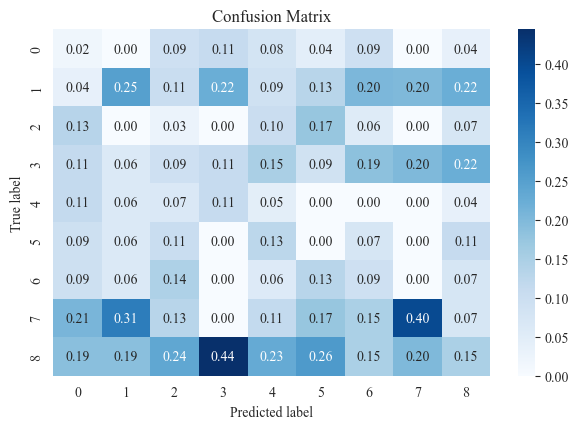

The overall accuracy is: 0.0657
The precision score is: 0.1214
The recall score is: 0.0657
The F1 score is: 0.0681
The AUC score is: 0.5093

Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.04      0.03        23
           1       0.25      0.09      0.13        45
           2       0.03      0.07      0.04        27
           3       0.11      0.02      0.04        47
           4       0.05      0.22      0.08        18
           5       0.00      0.00      0.00        32
           6       0.09      0.16      0.12        32
           7       0.40      0.04      0.07        52
           8       0.15      0.05      0.08        74

    accuracy                           0.07       350
   macro avg       0.12      0.08      0.06       350
weighted avg       0.15      0.07      0.07       350



In [99]:
evaluate_model_performance(model, x_test, y_test)

***

## K-fold

In [ ]:
class Args_kfold:
    # arugments
    epochs=70
    bs=32
    lr=0.0001
    momentum=0.9
    num_classes= 3
    split=5
    seed=710674

args_kfold = Args_kfold()

In [ ]:
class kfoldMLP:
    def __init__(self, input_dim, layer_configs, output_units, output_activation='softmax'):
        self.input_dim = input_dim
        self.layer_configs = layer_configs
        self.output_units = output_units
        self.output_activation = output_activation
        self.callbacks = []
        self.model = None
        
    def build_model(self):
        model = models.Sequential()
        
        ## add first hidden layer
        model.add(layers.Dense(units=self.layer_configs[0]['units'], 
                               activation=self.layer_configs[0]['activation'], 
                               input_shape=(self.input_dim,)))
        
        ## batch normalization and dropout for first layer
        if self.layer_configs[0].get('batch_norm', False):
            model.add(layers.BatchNormalization())
        
        if self.layer_configs[0].get('dropout_rate', None) is not None:
            model.add(layers.Dropout(rate=self.layer_configs[0]['dropout_rate']))
        
        ## do same for rest hidden layers (except for the last)
        for config in self.layer_configs[1:]:
            model.add(layers.Dense(units=config['units'], activation=config['activation']))
            
            if config.get('batch_norm', False):
                model.add(layers.BatchNormalization())
            
            if config.get('dropout_rate', None) is not None:
                model.add(layers.Dropout(rate=config['dropout_rate']))
        
        ## add output layer
        model.add(layers.Dense(units=self.output_units, activation=self.output_activation))
        self.model = model

    ## model compile
    def compile_model(self, optimizer, loss='categorical_crossentropy', metrics=['accuracy'], lr_scheduler=None):
        if lr_scheduler:
            self.callbacks.append(tf.keras.callbacks.LearningRateScheduler(lr_scheduler))

        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit_model(self, x_train, y_train, epochs, batch_size, validation_data=None, class_weight=None, verbose=0):
        return self.model.fit(
            x_train, y_train, 
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=validation_data, 
            callbacks=self.callbacks, 
            class_weight=class_weight,
            verbose=verbose
        )

    def evaluate_model(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        y_pred = self.model.predict(x)
        return np.array(y_pred)

    def summary(self):
        self.model.summary()

    def cross_validate(self, x_data, y_data, n_splits, epochs, batch_size, optimizer=None, class_weight=None):
        x_data = np.array(x_data)
        y_data = np.array(y_data)
        kf = KFold(n_splits=n_splits, shuffle=True) ##set fold split and shuffle
        fold_metrics = []

        for fold, (train_index, val_index) in enumerate(kf.split(x_data), 1):
            x_train, x_val = x_data[train_index], x_data[val_index]
            y_train, y_val = y_data[train_index], y_data[val_index]

            ## build new model
            self.build_model()
            self.compile_model(optimizer=optimizer)
            
            ## model training
            self.fit_model(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), class_weight=class_weight, verbose=0)
            
            ## evaluate the model
            y_val_pred = self.predict(x_val)
            if isinstance(y_val_pred, list):
                y_val_pred = np.array(y_val_pred)
            y_val_pred = np.argmax(y_val_pred, axis=1)
            y_val_true = np.argmax(y_val, axis=1)
            
            accuracy = accuracy_score(y_val_true, y_val_pred)
            precision = precision_score(y_val_true, y_val_pred, average='macro')
            recall = recall_score(y_val_true, y_val_pred, average='macro')
            f1 = f1_score(y_val_true, y_val_pred, average='weighted')
            auc = roc_auc_score(y_val, self.predict(x_val), multi_class='ovr')
            
            fold_metrics.append({
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'auc': auc
            })

            print(f"Fold metrics: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1 Score={f1:.4f}, AUC={auc:.4f}")
        
        avg_metrics = {key: np.mean([m[key] for m in fold_metrics]) for key in fold_metrics[0].keys()}
        
        print("\nAverage metrics across all folds:")
        for metric, value in avg_metrics.items():
            print(f"{metric.capitalize()}: {value:.4f}")

        return fold_metrics, avg_metrics

    ## evaluation on test dataset (for performance check)
    def evaluate_test_data(self, x_test, y_test):
        y_pred = self.predict(x_test)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true_labels = np.argmax(y_test, axis=1)

        # Confusion Matrix
        cm = confusion_matrix(y_true_labels, y_pred_labels, normalize='pred')
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        print("=============================================")

        # Classification Report
        class_report = classification_report(y_true_labels, y_pred_labels, target_names=[f'Class {i}' for i in range(self.output_units)])
        print("Classification Report:\n", class_report)

        return cm, class_report

In [ ]:
## model initialization with hidden layer list below
layer_configs = [
    {'units': 64, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.5},
    {'units': 32, 'activation': 'relu', 'batch_norm': False, 'dropout_rate': 0.3},
    {'units': 16, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.2}
]

kfold = kfoldMLP(output_units=args_kfold.num_classes, input_dim=x_train.shape[1], layer_configs=layer_configs)

In [ ]:
## compile our model
opt = keras.optimizers.SGD(learning_rate = 0.001, decay = 1e-5, momentum = 0.9)
scheduler = lambda epoch: dynamic_learning_rate(epoch, mode='triangular2', base_lr=0.001, max_lr=0.009, step_size=25)

## model summary
# model.summary()

In [ ]:
# K-Fold 교차 검증 실행
metrics, avg_metrics = kfold.cross_validate(x_train, y_train, n_splits=args_kfold.split, optimizer=opt, epochs=args_kfold.epochs, batch_size=args_kfold.bs)

# # 각 폴드의 성능 지표 출력
# for i, metric in enumerate(metrics):
#     print(f"Fold {i+1}: {metric}")

* Evaluation on test dataset

In [ ]:
cm, class_report = kfold.evaluate_test_data(x_test, y_test)

***

## 1D-Conv

In [ ]:
class Args_conv:
    # arugments
    epochs=70
    bs=16
    lr=0.0001
    momentum=0.9
    num_classes= 3
    split=5
    seed=710674

args_conv = Args_conv()

In [ ]:
class Conv1Dmodel:
    def __init__(self, input_shape, conv_layers, dense_layers, output_units, output_activation='softmax'):
        self.input_shape = input_shape
        self.conv_layers = conv_layers
        self.dense_layers = dense_layers
        self.output_units = output_units
        self.output_activation = output_activation
        self.model = None
        self.callbacks = []

    def build_model(self):
        model = Sequential()

        # Add Conv1D layers
        for i, config in enumerate(self.conv_layers):
            if i == 0:
                model.add(Conv1D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'],
                    activation=config['activation'],
                    input_shape=self.input_shape
                ))
            else:
                model.add(Conv1D(
                    filters=config['filters'],
                    kernel_size=config['kernel_size'],
                    activation=config['activation']
                ))

            if 'pool_size' in config:
                model.add(MaxPooling1D(pool_size=config['pool_size']))

        # Add Flatten layer
        model.add(Flatten())

        # Add Dense layers
        for config in self.dense_layers:
            model.add(Dense(
                units=config['units'],
                activation=config['activation']
            ))
            if config.get('batch_norm', False):
                model.add(BatchNormalization())
            if config.get('dropout_rate', None) is not None:
                model.add(Dropout(rate=config['dropout_rate']))

        # Add Output layer
        model.add(Dense(self.output_units, activation=self.output_activation))

        self.model = model

    def compile_model(self, optimizer, loss='categorical_crossentropy', metrics=['accuracy'], lr_scheduler=None):
        if lr_scheduler:
            self.callbacks.append(LearningRateScheduler(lr_scheduler))

        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit_model(self, x_train, y_train, epochs, batch_size, validation_data=None, class_weight=None, verbose=1):

        return self.model.fit(
            x_train, y_train, 
            epochs=epochs, 
            batch_size=batch_size, 
            validation_data=validation_data, 
            callbacks=self.callbacks, 
            class_weight=class_weight,
            verbose=verbose
        )

    def evaluate_model(self, x_test, y_test):
        return self.model.evaluate(x_test, y_test)

    def predict(self, x):
        return self.model.predict(x)

    def summary(self):
        if self.model:
            self.model.summary()

In [ ]:
## Define layer configurations
conv_layers = [
    {'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'pool_size': 3},
    {'filters': 16, 'kernel_size': 3, 'activation': 'relu', 'pool_size': 3}
]

dense_layers = [
    {'units': 64, 'activation': 'relu', 'batch_norm': True, 'dropout_rate': 0.5},
    {'units': 32, 'activation': 'relu'}
]

In [ ]:
input_shape = (x_train.shape[1], 1)
conv1d = Conv1Dmodel(input_shape = input_shape, conv_layers=conv_layers, dense_layers=dense_layers, output_units=args_conv.num_classes)
conv1d.build_model()

In [ ]:
opt = keras.optimizers.SGD(learning_rate = 0.001, decay = 1e-5, momentum = 0.9)
scheduler = lambda epoch: dynamic_learning_rate(epoch, mode='triangular2', base_lr=0.001, max_lr=0.009, step_size=25)

conv1d.compile_model(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], lr_scheduler=scheduler)

In [ ]:
# Train the model
history = conv1d.fit_model(x_train, y_train, epochs=args_conv.epochs, batch_size=args_conv.bs, class_weight=class_weight, verbose=2)

* Model evaluation

In [ ]:
evaluate_model_performance(conv1d, x_test, y_test)

***

***

## Sub-networks

In [ ]:
class Args_multi:
    # arugments
    epochs=80
    enc_epochs = 50
    bs=32
    enc_bs = 16
    lr=0.0001
    momentum=0.9
    num_classes= 3
    seed=710674

args_multi = Args_multi()

In [ ]:
data_x_, data_y_ = data_x.copy(), data_y.copy()

* preprocessing the partial dataframes for subnetwork training

In [ ]:
class subnetwork_preprocess:
    def __init__(self, data):
        self.data = data
        self.data_dict = {}

    def select_columns(self, prefixes):
        self.data_dict = {prefix: self.data.loc[:, self.data.columns.str.startswith(f'{prefix}_')] 
                          for prefix in prefixes}
        return self.data_dict

    def create_inputs(self):
        self.inputs = {name: Input(shape=(data.shape[1],)) for name, data in self.data_dict.items()}
        return self.inputs

In [ ]:
## defining prefixies (criteria for variable selection)
prefixes = ['b1', 's', 'b2', 'r', 'b3', 'c']

## pass dataframe to generate class instance
processor = subnetwork_preprocess(data_x_)

## data columns selection based on the prefix
data_dict = processor.select_columns(prefixes)

## create input layers(for keras) with selected prefix inputs
inputs = processor.create_inputs()

In [ ]:
## 각 입력 레이어에 접근
input_b1, input_s, input_b2, input_r, input_b3, input_c = inputs['b1'], inputs['s'], inputs['b2'], inputs['r'], inputs['b3'], inputs['c']

## 각 변수별 데이터셋 추출
data_b1, data_s, data_b2, data_r, data_b3, data_c = data_dict['b1'], data_dict['s'], data_dict['b2'], data_dict['r'], data_dict['b3'], data_dict['c']

* Creating commonly using sub-network

In [ ]:
class subnetModel:
    def __init__(self, input_layers):
        self.input_layers = input_layers
    
    ## subnetwork(AE structure) for each variable group
    def create_subnetworks(self, input_layer):
        x = Dense(32, activation='relu')(input_layer)
        x = BatchNormalization()(x)
        x = Dense(16, activation='relu')(x)
        x = BatchNormalization()(x)
        # x = Dropout(0.3)(x)
        x = Dense(8, activation='relu')(x)
        return x

    def build_subnetworks(self):
        return {name: self.create_subnetworks(layer) for name, layer in self.input_layers.items()}

    ## combined network: subnetworks + fully-connected layers
    def build_combined(self, subnetworks):
        combined = Concatenate()(list(subnetworks.values()))
        x = Dense(64, activation='relu')(combined)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)
        x = Dense(16, activation='relu')(x)
        x = Dense(8, activation='relu')(x)
        return x

    def build_final_output(self, combined_x, num_classes):
        return Dense(num_classes, activation='softmax')(combined_x)

In [ ]:
# 사용 예시:
input_layers = {
    'b1': input_b1,
    's': input_s,
    'b2': input_b2,
    'r': input_r,
    'b3': input_b3,
    'c': input_c
}

model_builder = subnetModel(input_layers)
subnetworks = model_builder.build_subnetworks()
combined_x = model_builder.build_combined(subnetworks)

# 최종 출력 레이어 정의 (4-class 분류, args_multi.num_classes 사용)
final_output = model_builder.build_final_output(combined_x, args_multi.num_classes)

In [ ]:
subnetworks

* Train-test dataset split

In [ ]:
## preparing training dataset and test dataset
b1_train, b1_test, s_train, s_test, b2_train, b2_test, r_train, r_test, b3_train, b3_test, c_train, c_test, y_train, y_test = train_test_split(
    data_b1, data_s, data_b2, data_r, data_b3, data_c, data_y_, test_size=0.2, random_state=710674)

* Optimization function and learning rate scheduler settings, model compile

In [ ]:
lr_scheduler = dynamic_learning_rate(args_multi.epochs, mode='cyclic')
opt = keras.optimizers.SGD(learning_rate = args_multi.lr, decay = 1e-6, momentum = args_multi.momentum)

model = Model(inputs=[input_b1, input_s, input_b2, input_r, input_b3, input_c], outputs=final_output)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit([b1_train, s_train, b2_train, r_train, b3_train, c_train], y_train, 
          epochs=args_multi.epochs, batch_size=args_multi.bs, 
          validation_split=0.2, verbose=2)

* Model evaluation

In [ ]:
evaluate_model_performance(model, [b1_test, s_test, b2_test, r_test, b3_test, c_test], y_test)

***

***

## Using VAE/AE as a dimensionality reduction

In [ ]:
x = data_x
y = y

In [ ]:
class Args:
    # arugments
    epochs=200
    enc_epochs = 50
    bs=32
    enc_bs = 16
    lr=0.001
    momentum=0.9
    encoding_dim = 16
    num_classes= 2
    verbose='store_true'
    seed=710674

args = Args()

### Autoencoder for dim reduction

In [ ]:
# input dataset layer
input_layer = Input(shape=(x.shape[1],))

# encoder layers
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)
encoder_out = Dense(args.encoding_dim, activation='relu')(encoder)

# decoder layers
decoder = Dense(32, activation='relu')(encoder_out)
decoder = Dense(64, activation='relu')(decoder)
decoder_out = Dense(x.shape[1], activation='sigmoid')(decoder)

In [ ]:
# AE model
autoencoder = Model(inputs=input_layer, outputs=decoder_out)

# Encoder model (convert input dataset into latent space)
encoder_model = Model(inputs=input_layer, outputs=encoder_out)

# Decoder model (recover latent space/vector into original dataset format)
encoded_input = Input(shape=(args.encoding_dim,))
decoder_layer = autoencoder.layers[-3](encoded_input)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_out = autoencoder.layers[-1](decoder_layer)
decoder_model = Model(inputs=encoded_input, outputs=decoder_layer)

In [ ]:
# Model compile
autoencoder.compile(optimizer='adam', loss='mse')

# Checking each model
autoencoder.summary()
# encoder_model.summary()
# decoder_model.summary()

In [ ]:
## Model training
autoencoder.fit(x, x, epochs = args.enc_epochs, batch_size = args.enc_bs, shuffle=True, validation_split=0.2, verbose=2)

In [ ]:
encoded_data = encoder_model.predict(x)
decoded_data = decoder_model.predict(encoded_data)

In [ ]:
encoded_data.shape

In [ ]:
decoded_data.shape

In [ ]:
y.shape

In [ ]:
decoded_data

In [ ]:
class Args:
    # arugments
    epochs=200
    bs=32
    lr=0.001
    momentum=0.9
    num_classes= 2
    verbose='store_true'
    seed=710674

args = Args()

# np.random.seed(args.seed)
# random.seed(args.seed)
# torch.manual_seed(args.seed)

In [ ]:
x_trainset, x_test, y_trainset, y_test = train_test_split(decoded_data, y, test_size = 0.1, random_state = 710674)
x_train, x_vali, y_train, y_vali = train_test_split(x_trainset, y_trainset, test_size = 0.2, random_state = 710674)

In [ ]:
inputs = np.concatenate((x_train, x_vali), axis = 0)
targets = np.concatenate((y_train, y_vali), axis = 0)

In [ ]:
fold_num = 1
split_num = 5
opt = keras.optimizers.SGD(learning_rate = args.lr, decay = 1e-6, momentum = args.momentum)
kfold = KFold(n_splits = split_num, shuffle = True)
# kfold = StratifiedKFold(n_splits = split_num, shuffle = True)

In [ ]:
############## FOR FOUR-GROUP CLASSIFICATION ###############
class_weight = {0:1, 1: 1.68}

In [ ]:
acc_per_fold = []
loss_per_fold = []

In [ ]:
for train, test in kfold.split(inputs, targets):
    model = Sequential()
    model.add(Dense(128, input_dim = x_train.shape[1], activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5)) #drop out
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(args.num_classes, activation = 'softmax'))
    
    ## model compile
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
    print('----------------------------------------')
    print(f'Training or fold {fold_num} ... ')
    
    ## fit data to model
    history = model.fit(inputs[train], targets[train], batch_size = args.bs, epochs = args.epochs, verbose = 0, class_weight = class_weight)
    
    ## generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test])
    print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    ## increasing fold number
    fold_num = fold_num + 1
    
    
    
## Summarizing the results
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'>> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'>>> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'>>> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In [ ]:
y_predict = model.predict(x_test)
y_predict = np.argmax(y_predict, axis = 1)
y_test = np.argmax(y_test, axis = 1)

result = confusion_matrix(y_test, y_predict, normalize = 'pred')
print(result)

In [ ]:
figure = plt.figure(figsize=(6, 4))
sns.heatmap(result, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
accuracy = metrics.accuracy_score(y_test, y_predict)
precision = metrics.precision_score(y_test, y_predict, average = 'macro')
recall = metrics.recall_score(y_test, y_predict, average = 'micro')
f1 = metrics.f1_score(y_test, y_predict, average = 'weighted')
auc = roc_auc_score(y_test, model.predict(x_test, verbose=0), multi_class='ovr')

print("=============================================")
print("The overall accuracy is:", round(accuracy, 4))
print("The precision score is:", round(precision, 4))
print("The recall score is:", round(recall, 4))
print("The f1 score is:", round(f1, 4))
print("The AUC score is:", round(auc, 4))
print("=============================================")

## EV input & MV output

> What if we use external variables(ex. demographics) as input variables and set the DNN model to find Medical Variables as an output variables?

### data setup

In [ ]:
data_evinput = data_ori.copy()

In [ ]:
data_evinput['disorder'] = data_evinput['disorder'].replace({"mdd": 0})
data_evinput['disorder'] = data_evinput['disorder'].replace({"pd": 1})
data_evinput['disorder'] = data_evinput['disorder'].replace({"con": 2})

In [ ]:
# data_evinput.head()
# data_evinput.columns

In [ ]:
scale_list = ['HAMD', 'HAMA', 'PDSS', 'ASI', 'APPQ', 'PSWQ', 'SPI', 'PSS', 'BIS', 'SSI']
etc_list = ['sub', 'VISIT', 'disorder_mdd']
demo_list = ['age', 'gender', 'disorder']

In [ ]:
ev_input = data_evinput.loc[:, ('disorder', 'age', 'gender')]
ev_output = data_evinput.drop((scale_list + etc_list + demo_list), axis=1)

In [ ]:
scaler = MinMaxScaler() #set the scaler (between 0 and 1)

ev_input[:] = (scaler.fit_transform(ev_input[:])).round(decimals=6)
ev_output[:] = (scaler.fit_transform(ev_output[:])).round(decimals=6)

### Model

In [ ]:
input_dim = ev_input.shape[1]
output_dim = ev_output.shape[1]

In [ ]:
# 모델 구조 정의
ev_model = Sequential([
    Dense(16, input_dim=input_dim, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'), 
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(output_dim)
])

In [ ]:
# 모델 컴파일
ev_model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 요약 출력
ev_model.summary()

In [ ]:
# 학습 예시 (X_train은 인구학적 변수, Y_train은 생체신호 변수)
ev_model.fit(ev_input, ev_output, epochs=100, batch_size=32, validation_split=0.2)

***

***

# Class generic/specific feature

> Concept: generate seperate class(var) generic feature and class specific feature extraction models. \
> Maybe implement individual autoencoder model and train the subset datasets. \
> Then concatenate the extracted features, and adopt the feature vector for classifier's input.

In [ ]:
data = data_ori.copy()

In [ ]:
data.columns

In [ ]:
non_hrv = ['sub', 'VISIT', 'age', 'gender', 'HAMD', 'HAMA', 'PDSS', 'ASI', 'APPQ', 'PSWQ', 'SPI', 'PSS', 'BIS', 'SSI', 'disorder_mdd']
target = ['disorder']

## Class-generic

In [ ]:
data_generic = data.drop(non_hrv, axis=1)

In [ ]:
len(data_generic.columns)

In [ ]:
data.gender.value_counts()

## Class-specific

In [ ]:
data_spe_M = data_ori[data_ori['gender']==1]
data_spe_F = data_ori[data_ori['gender']==2]

In [ ]:
data_specific = data_spe_M.drop(non_hrv, axis=1)
# data_specific = data_spe_F.drop(non_hrv, axis=1)

In [ ]:
x = data_specific.drop('disorder', axis=1)
y = data_specific.disorder

In [ ]:
data_x = x.copy()
data_x[:] = (scaler.fit_transform(data_x[:])).round(decimals=6) ## scaling x values

label = y.copy()
label = label.replace({'mdd': 0})
label = label.replace({'pd': 1})
label = label.replace({'con' : 2})
data_y = to_categorical(label, 3) ## into the format of one-hot encoding

In [ ]:
print("The size of x dataset is:", data_x.shape)
print("The size of y dataset is:", data_y.shape)

In [ ]:
class specific_AE:
    def __init__(self, input_dim, encoding_dim, hidden_layers=None, batch_norm=False, dropout_rate=0.0):
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        self.hidden_layers = hidden_layers if hidden_layers is not None else []
        self.batch_norm = batch_norm
        self.dropout_rate = dropout_rate

        self.encoder = None
        self.decoder = None
        self.autoencoder = None

        self._build()

    def _build(self):
        ## building encoder part
        input_layer = layers.Input(shape=(self.input_dim,))
        x = input_layer

        for units in self.hidden_layers:
            x = layers.Dense(units, activation='relu')(x)
            if self.batch_norm:
                x = layers.BatchNormalization()(x)
            if self.dropout_rate > 0.0:
                x = layers.Dropout(self.dropout_rate)(x)

        encoded = layers.Dense(self.encoding_dim, activation='relu')(x)

        ## building decodeer part
        x = encoded
        for units in reversed(self.hidden_layers):
            x = layers.Dense(units, activation='relu')(x)
            if self.batch_norm:
                x = layers.BatchNormalization()(x)
            if self.dropout_rate > 0.0:
                x = layers.Dropout(self.dropout_rate)(x)

        decoded = layers.Dense(self.input_dim, activation='softmax')(x)

        # 인코더, 디코더, 오토인코더 모델
        self.encoder = models.Model(input_layer, encoded, name='encoder')
        self.decoder = models.Model(encoded, decoded, name='decoder')
        self.autoencoder = models.Model(input_layer, self.decoder(self.encoder(input_layer)), name='autoencoder')

        self.autoencoder.compile(optimizer='adam', loss='mse')

    def summary(self):
        self.autoencoder.summary()

    def train(self, X_train, X_val=None, epochs=50, batch_size=256):
        return self.autoencoder.fit(X_train, X_train, 
                                    validation_data=(X_val, X_val) if X_val is not None else None,
                                    epochs=epochs, batch_size=batch_size)

    def encode(self, X):
        return self.encoder.predict(X)

    def decode(self, encoded_data):
        return self.decoder.predict(encoded_data)

    def reconstruct(self, X):
        return self.autoencoder.predict(X)

In [ ]:
data_x.shape

In [ ]:
# 사용 예시
input_dim = data_x.shape[1]
encoding_dim = 8
hidden_layers = [64, 32, 16]

autoencoder = specific_AE(input_dim, encoding_dim, hidden_layers, batch_norm=True, dropout_rate=0.2)
autoencoder.summary()

In [ ]:
autoencoder.train(data_x, data_x, epochs=100, batch_size=16)

***

***

# Code practice

* Practicing multi-head attention mask for significant feature extraction

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
data_prac = df.copy()

In [ ]:
data_prac.main_dx.value_counts()

In [ ]:
data_prac.shape

In [ ]:
data_prac['psi'] = pd.to_numeric(data_prac['psi'], errors='coerce')

In [ ]:
data_prac.head()

In [ ]:
info_list = ['subject' ,'gender', 'age']
scale_list = ['HAMD', 'HAMA', 'BDI-II', 'BAI', 'MDQ', 'HCL-32']
target_list = ['main_dx']
hr_list = ['auto_activity', 'auto_balance', 'stress_resist', 'stress_index', 'tired', 'avg_hr', 'heart_stable', 'abnormal_hr']

# drop_list = info_list + scale_list + target_list
drop_list = info_list + scale_list + target_list + hr_list

In [ ]:
signals = data_prac.drop(drop_list, axis=1)
signals[:] = (scaler.fit_transform(signals[:]).round(decimals=5))

In [ ]:
data_prac.main_dx.value_counts()

In [ ]:
genders = data_prac['gender'].map({'M': 0, 'F': 1}).values.reshape(-1, 1)
labels = data_prac['main_dx'].map({'MDDs': 0, 'MDDr': 1, 'PDD': 2}).values

In [ ]:
# Attention 레이어 정의
class GenderAttention(layers.Layer):
    def __init__(self, attention_dim):
        super(GenderAttention, self).__init__()
        self.query_dense = layers.Dense(attention_dim)
        self.key_dense = layers.Dense(attention_dim)
        self.value_dense = layers.Dense(attention_dim)
    
    def call(self, x, gender):
        # 성별과 생체신호 결합
        x_concat = layers.Concatenate()([x, gender])

        # Query, Key, Value 계산
        Q = self.query_dense(x_concat)
        K = self.key_dense(x_concat)
        V = self.value_dense(x_concat)

        # Attention score 계산 (Q * K^T / sqrt(d_k))
        attention_scores = tf.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(tf.shape(Q)[-1], tf.float32))

        # Attention weight에 softmax 적용
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # 가중합 (Attention output)
        attention_output = tf.matmul(attention_weights, V)

        return attention_output, attention_weights

# 분류 모델 정의
def create_model(input_dim, attention_dim, hidden_dim, output_dim):
    # 입력 정의
    signal_input = Input(shape=(input_dim,), name='signal_input')  # 생체신호 입력
    gender_input = Input(shape=(1,), name='gender_input')  # 성별 입력

    # GenderAttention 레이어 적용
    attention_output, attention_weights = GenderAttention(attention_dim)(signal_input, gender_input)

    # Hidden Layer
    x = layers.Dense(hidden_dim, activation='relu')(attention_output)
    
    # 출력 Layer (질병군 분류)
    output = layers.Dense(output_dim, activation='softmax')(x)

    # 모델 정의 (Functional API 사용)
    model = Model(inputs=[signal_input, gender_input], outputs=[output, attention_output])

    # 모델 컴파일
    model.compile(optimizer=Adam(),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model

In [ ]:
# 모델 생성
input_dim = len(signals.columns)  # 생체신호 변수의 개수
attention_dim = 8  # Attention dimension
hidden_dim = 32  # Hidden layer의 뉴런 개수
output_dim = 3  # 질병군 클래스 개수 (A, B, C)

In [ ]:
model = create_model(input_dim, attention_dim, hidden_dim, output_dim)

In [ ]:
# 모델 훈련
model.fit([signals, genders], labels, epochs=150, batch_size=8)

In [ ]:
# 모델 요약 출력
model.summary()

In [ ]:
# Attention Output 및 예측 결과 얻기
predictions, attention_output = model.predict([signals, genders])

# Attention Output 확인
print("Attention Output Shape:", attention_output.shape)
print("Attention Output Sample:\n", attention_output[:5])  # 샘플 출력

In [ ]:
# 원본 signals와 attention output 결합
combined_input = np.concatenate((signals, attention_output), axis=1)  # 열 방향으로 결합

# 결합된 입력 데이터의 shape 확인
print("Combined Input Shape:", combined_input.shape)

In [ ]:
# 새로운 분류 모델 정의
def create_combined_model(input_dim, hidden_dim, output_dim):
    # 입력 정의
    combined_input = Input(shape=(input_dim,), name='combined_input')  # combined_input 크기 설정

    # Hidden Layer
    x = layers.Dense(hidden_dim, activation='relu')(combined_input)
    
    # 출력 Layer (질병군 분류)
    output = layers.Dense(output_dim, activation='softmax')(x)

    # 모델 정의
    model = Model(inputs=combined_input, outputs=output)

    # 모델 컴파일
    model.compile(optimizer=Adam(),
                  loss=SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model

# 원본 signals와 attention output 결합
combined_input = np.concatenate((signals, attention_output), axis=1)  # 열 방향으로 결합

# 새로운 모델 정의 및 학습
input_dim = combined_input.shape[1]  # combined_input의 입력 차원
combined_model = create_combined_model(input_dim, 64, 3)  # 새로운 모델 생성
combined_model.fit(combined_input, labels, epochs=200, batch_size=8)  # 새로운 모델 학습

# 학습 결과 평가
loss, accuracy = combined_model.evaluate(combined_input, labels)
print(f"Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

In [ ]:
attention_weights[0]

In [ ]:
# Attention Output 성별에 따른 평균 비교
male_attention_output = attention_output[genders.flatten() == 0]
female_attention_output = attention_output[genders.flatten() == 1]

print("Male Attention Output Mean:\n", male_attention_output.mean(axis=0))
print("Female Attention Output Mean:\n", female_attention_output.mean(axis=0))

> How can we adopt gender characteristic to extract significant features from signals?

In [ ]:
class GenderAttention(layers.Layer):
    def __init__(self, attention_dim):
        super(GenderAttention, self).__init__()
        self.male_query_dense = layers.Dense(attention_dim)
        self.male_key_dense = layers.Dense(attention_dim)
        self.male_value_dense = layers.Dense(attention_dim)

        self.female_query_dense = layers.Dense(attention_dim)
        self.female_key_dense = layers.Dense(attention_dim)
        self.female_value_dense = layers.Dense(attention_dim)
    
    def call(self, x, gender):
        male_mask = tf.cast(gender == 0, tf.float32)
        female_mask = tf.cast(gender == 1, tf.float32)
        
        male_Q = self.male_query_dense(x) * male_mask
        male_K = self.male_key_dense(x) * male_mask
        male_V = self.male_value_dense(x) * male_mask
        
        female_Q = self.female_query_dense(x) * female_mask
        female_K = self.female_key_dense(x) * female_mask
        female_V = self.female_value_dense(x) * female_mask
        
        Q = male_Q + female_Q
        K = male_K + female_K
        V = male_V + female_V

        # Attention score 계산 시 너무 큰 값 방지를 위해 평균을 뺀 후 softmax 적용
        attention_scores = tf.matmul(Q, K, transpose_b=True) / tf.sqrt(tf.cast(tf.shape(Q)[-1], tf.float32))
        
        # 평균 제거로 안정화
        attention_scores -= tf.reduce_mean(attention_scores, axis=-1, keepdims=True)
        
        # softmax 적용
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        # 가중합 (Attention output)
        attention_output = tf.matmul(attention_weights, V)

        return attention_output, attention_weights

In [ ]:
# 모델 정의
def create_model(input_dim, attention_dim, hidden_dim, output_dim):
    # 입력 정의
    signal_input = Input(shape=(input_dim,), name='signal_input')
    gender_input = Input(shape=(1,), name='gender_input')

    # GenderAttention 레이어 적용
    attention_output, attention_weights = GenderAttention(attention_dim)(signal_input, gender_input)

    # Hidden Layer
    x = layers.Dense(hidden_dim, activation='relu')(attention_output)
    
    # 출력 Layer (질병군 분류)
    output = layers.Dense(output_dim, activation='softmax')(x)

    # 모델 정의
    model = Model(inputs=[signal_input, gender_input], outputs=[output, attention_weights])

    # 모델 컴파일
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# # 샘플 데이터 생성 (100개의 샘플)
# signals = np.random.randn(100, 17).astype(np.float32)  # 생체신호 변수 (17개)
# genders = np.random.randint(0, 2, (100, 1)).astype(np.float32)  # 성별 (M:0, F:1)
# labels = np.random.randint(0, 3, (100,))  # 질병군 (A:0, B:1, C:2)

# 모델 생성 및 학습
model = create_model(input_dim=17, attention_dim=8, hidden_dim=24, output_dim=3)
model.fit([signals, genders], labels, epochs=50, batch_size=8)

# Attention Output 및 Weights 얻기
predictions, attention_weights = model.predict([signals, genders])


In [ ]:
labels